In [1]:
from shapely.geometry import Polygon
from matplotlib import pyplot as plt
import geopandas as gpd
from tqdm import tqdm
import numpy as np
import requests
import time
import math
import cv2
import os

In [2]:
SAVE_PATH = os.path.join(os.getcwd(), 'data', 'sii')

In [3]:
from pyproj import Proj, transform

# Define the source CRS (EPSG:4326) and target CRS (EPSG:3857)
src_proj = Proj(init="EPSG:4326")
tgt_proj = Proj(init="EPSG:3857")

# Input geographic bounding box in EPSG:4326
west_bound_longitude = -70.706376
east_bound_longitude = -70.508253
south_bound_latitude = -34.244582
north_bound_latitude = -34.153585

# Convert to EPSG:3857
west, south = transform(src_proj, tgt_proj, west_bound_longitude, south_bound_latitude)
east, north = transform(src_proj, tgt_proj, east_bound_longitude, north_bound_latitude)

# Add 1 km safety margin (1,000 meters)
safety_margin = 1000  # 1 km in meters
west -= safety_margin
south -= safety_margin
east += safety_margin
north += safety_margin

# Output in the desired format
output = f"{west},{south},{east},{north}"
print(output)

-7871997.772157741,-4062690.8844779152,-7847942.820683304,-4048443.4300574814


/home/vicenteaguero/Desktop/Building/Portfolio/ideas/sii_polygons/.venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/vicenteaguero/Desktop/Building/Portfolio/ideas/sii_polygons/.venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_145848/160809871.py:14: FutureWarning: This function is deprecated. See: https://pyproj4.

In [4]:
def estimate_number_of_boxes(xmin, ymin, xmax, ymax, offset, factor):
    offset_scaled = offset * factor
    # Use math.ceil to include partial tiles accurately
    num_x = math.ceil((xmax - xmin) / offset_scaled)
    num_y = math.ceil((ymax - ymin) / offset_scaled)
    total_boxes = num_x * num_y
    return num_x, num_y, total_boxes

# -7871997.772157741,-4062690.8844779152,-7847942.820683304,-4048443.4300574814
xmin = -7871997.772157741
ymin = -4062690.8844779152
xmax = -7847942.820683304
ymax = -4048443.4300574814

offset = 76.437028285
factor = 9

num_x, num_y, total_boxes = estimate_number_of_boxes(xmin, ymin, xmax, ymax, offset, factor)
print(f"Number of boxes: {total_boxes}")
print(f"Number of boxes in x: {num_x}")
print(f"Number of boxes in y: {num_y}")

Number of boxes: 735
Number of boxes in x: 35
Number of boxes in y: 21


In [5]:
def compute_combined_bbox(bboxes, safety_margin=1000):
    # Initialize with extreme values
    xmin = float("inf")
    ymin = float("inf")
    xmax = float("-inf")
    ymax = float("-inf")
    
    # Iterate over each bbox to find the combined bounds
    for bbox in bboxes:
        bbox_xmin, bbox_ymin, bbox_xmax, bbox_ymax = bbox
        xmin = min(xmin, bbox_xmin)
        ymin = min(ymin, bbox_ymin)
        xmax = max(xmax, bbox_xmax)
        ymax = max(ymax, bbox_ymax)
    
    # Add safety margin
    xmin -= safety_margin
    ymin -= safety_margin
    xmax += safety_margin
    ymax += safety_margin
    
    return xmin, ymin, xmax, ymax

# Input bounding boxes in EPSG:3857
bboxes = [
    (-7872861.039316583, -4056513.091094305, -7872708.165260013, -4056360.2170377346),
    (-7820730.986026093, -4123930.55004183, -7820425.237912953, -4123624.801928687),
    (-7793825.152069711, -4084183.2953335373, -7793748.715041426, -4084106.858305252),
    (-7830514.925646596, -4030065.8793076333, -7830438.488618311, -4029989.4422793468)
]

# Compute the combined bounding box with a 1 km safety margin
xmin, ymin, xmax, ymax = compute_combined_bbox(bboxes)

# Save in the requested format
result = f"""
xmin = {xmin}
ymin = {ymin}
xmax = {xmax}
ymax = {ymax}
"""

print(result)


xmin = -7873861.039316583
ymin = -4124930.55004183
xmax = -7792748.715041426
ymax = -4028989.4422793468



In [8]:
url = 'https://www4.sii.cl/mapasui/services/ui/wmsProxyService/call'

comuna = 'machali'
comuna_id = 6102

xmin = -7873861.039316583
ymin = -4124930.55004183
xmax = -7792748.715041426
ymax = -4028989.4422793468
offset = 76.437028285
factor = 16
size = 256

bboxes = list()
offset_scaled = offset * factor

# Start positions
current_x_min = xmin
current_y_max = ymax

while current_y_max > ymin:  # Continue until the bottom of the grid
    current_x_min = xmin
    while current_x_min < xmax:  # Continue until the right of the grid
        x_min = current_x_min
        y_max = current_y_max
        x_max = x_min + offset_scaled
        y_min = y_max - offset_scaled
        bbox = f'{x_min},{y_min},{x_max},{y_max}'
        bboxes.append(bbox)
        current_x_min += offset_scaled
    current_y_max -= offset_scaled
    
# Randomize the order of the bboxes
np.random.shuffle(bboxes)


# bbox -> xmin, ymin, xmax, ymax
# bboxes = [
#     '-7855662.707952418,-3945297.214939372,-7855586.270924133,-3945220.777911087',
#     '-7855280.522810993,-3945297.214939372,-7855204.085782708,-3945220.777911087',
#     '-7854821.900641282,-3947361.0147030726,-7854745.463612997,-3947284.577674787',
#     '-7854745.463612997,-3947361.0147030726,-7854669.026584712,-3947284.577674787',
#     '-7854821.900641282,-3947437.4517313577,-7854745.463612997,-3947361.0147030726',
#     '-7854745.463612997,-3947437.4517313577,-7854669.026584712,-3947361.0147030726',
#     '-7854745.463612997,-3947284.577674787,-7854669.026584712,-3947208.140646502',
#     '-7854898.337669567,-3947361.0147030726,-7854821.900641282,-3947284.577674787',
#     '-7854669.026584712,-3947361.0147030726,-7854592.589556426,-3947284.577674787',
#     '-7854898.337669567,-3947437.4517313577,-7854821.900641282,-3947361.0147030726',
#     '-7854669.026584712,-3947437.4517313577,-7854592.589556426,-3947361.0147030726',
#     '-7854821.900641282,-3947513.888759643,-7854745.463612997,-3947437.4517313577',
# ]

payload = {
    'service': 'WMS',
    'request': 'GetMap',
    'layers': f'sii:BR_CART_{comuna.upper().replace(' ', '_')}_WMS',
    'styles': 'PREDIOS_WMS_V0',
    'format': 'image/png',
    'transparent': 'true',
    'version': '1.1.1',
    'comuna': str(comuna_id),
    'eac': '0',
    'eacano': '0',
    'srs': 'EPSG:3857',
}

comuna_path = os.path.join(SAVE_PATH, payload['comuna'])
os.makedirs(comuna_path, exist_ok=True)

# print(f'Requesting {len(bboxes)} tiles')
# print(f'Image size: {size*factor}x{size*factor}')
# xmins = list()
# for bbox in tqdm(bboxes):
#     xmin, ymin, xmax, ymax = map(float, bbox.split(','))
#     xmin_folder = os.path.join(comuna_path, str(int(xmin)))
#     xmins.append(xmin_folder)
# xmins = list(set(xmins))
# for xmin_folder in xmins:
#     os.makedirs(xmin_folder, exist_ok=True)
# total_errors = list()
# for bbox in tqdm(bboxes):
#     payload['bbox'] = bbox
#     payload['width'] = size*factor
#     payload['height'] = size*factor
#     xmin, ymin, xmax, ymax = map(float, bbox.split(','))
#     xmin_folder = os.path.join(comuna_path, str(int(xmin)))
#     save_file = os.path.join(xmin_folder, payload['bbox']+'.png')
#     if os.path.exists(save_file):
#         print('File already exists')
#         continue
#     r = requests.get(url, params=payload)
#     if r.status_code == 200:
#         with open(os.path.join(SAVE_PATH, save_file), 'wb') as f:
#             f.write(r.content)
#     else:
#         print('Error:', r.status_code)
#         print(r.text)
#         total_errors.append(bbox)
#         time.sleep(60)
#     time.sleep(1)
# print(f'Errors: {len(total_errors)}')

-7865300
-7865300.0921486635,-4054672.2837831066,-7864077.0996961035,-4053449.2913305466.png


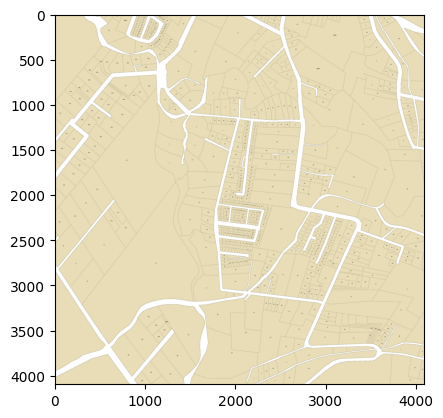

In [11]:
search = '-7864758.714318355,-4054143.5432174625,-7864682.2772900695,-4054067.1061891774'
xmin, ymin, xmax, ymax = map(float, search.split(','))

xmin_folder = [x for x in os.listdir(comuna_path) if (xmin >= int(x)) and (xmax <= int(x)+offset*factor)][0]
for file in os.listdir(os.path.join(comuna_path, xmin_folder)):
    x_min, y_min, x_max, y_max = map(float, file.split('.png')[0].split(','))
    if (x_min <= xmin) and (y_min <= ymin) and (x_max >= xmax) and (y_max >= ymax):
        print(xmin_folder)
        print(file)
        img = cv2.imread(os.path.join(comuna_path, xmin_folder, file))
        plt.imshow(img)
        plt.show()